# Gradient Descent Showcase
### (Batch, Stochastic, and Mini-Batch)

This notebook demonstrates and compares the three optimization algorithms implemented in `gradient_descent.py`.

1.  **Contour Plot Comparison:** We visualize the path of Batch Gradient Descent (with a fixed step vs. line search) on the 2D Rosenbrock function.
2.  **Application Plot (Linear Regression):** We compare the convergence speed (loss curves) of Batch GD, SGD, and Mini-Batch GD on a linear regression dataset.

In [5]:
import sys
import os

# Get the current working directory (e.g., .../Optimization_Project/notebooks)
current_dir = os.getcwd()

# Get the parent directory (e.g., .../Optimization_Project/)
parent_dir = os.path.dirname(current_dir)

# Add the parent directory to the system path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    print(f"Added '{parent_dir}' to sys.path")

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Import base classes and helpers
from utils.base import Function
from utils.plot_helpers import plot_loss_curves, plot_contour_comparison

# Import test functions
from utils.test_functions import (
    Rosenbrock, 
    Quadratic, 
    generate_linear_regression_data, 
    linear_regression_loss, 
    linear_regression_gradient
)

# Import the optimizers we are testing
from optimizers.gradient_descent import (
    GradientDescent, 
    StochasticGradientDescent, 
    MiniBatchGradientDescent
)

# Import a line search method for comparison
from optimizers.line_search import BacktrackingLineSearch

# Magic command for plotting
%matplotlib inline

## 1. Contour Plot: Batch GD (Fixed vs. Line Search)

This plot shows the optimization path on a 2D function. We compare a `GradientDescent` optimizer using a small, fixed learning rate against one using `BacktrackingLineSearch` to find the optimal step size at each iteration.

Running Batch GD (Fixed Step)...
Found solution: [0.99999888 0.99999772] in 0 iterations.

Running Batch GD (Line Search)...
Found solution: [0.99999888 0.99999772] in 0 iterations.



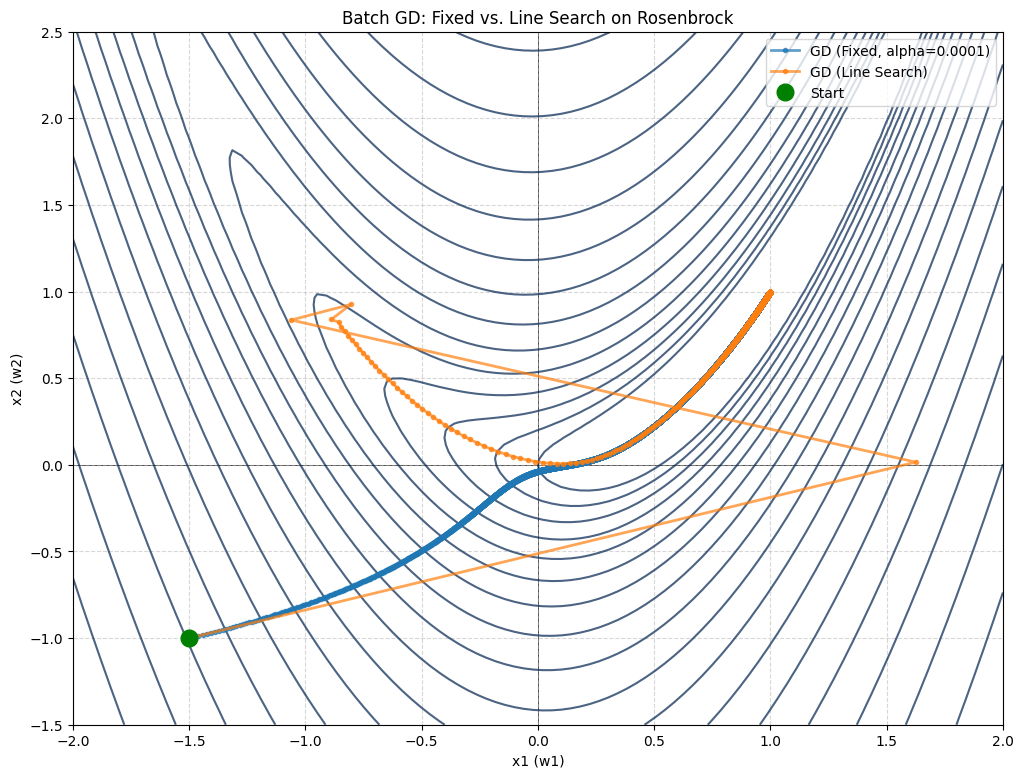

In [7]:
# --- 1. Define Optimizers ---

# Optimizer with a small, fixed step size
# Rosenbrock is very sensitive, so a standard alpha=0.01 will explode.
gd_fixed = GradientDescent(alpha=0.0001)

# Optimizer with Backtracking Line Search
# We create an instance of the line search optimizer first
line_search_optim = BacktrackingLineSearch(alpha_init=1.0, beta=0.5, c1=1e-4)
# We then pass the line search optimizer to GradientDescent
gd_line_search = GradientDescent(alpha=1.0, alpha_optim=line_search_optim)

# --- 2. Define Problem ---
start_point = np.array([-1.5, -1.0])

# --- 3. Run Optimizations ---
print("Running Batch GD (Fixed Step)...")
# We call optimize() with is_plot=True to get the history
sol_fixed, history_fixed = gd_fixed.optimize(
    x=start_point.copy(),
    func_callback=Rosenbrock,
    grad_func_callback=Rosenbrock.grad,
    hessian_func_callback=Rosenbrock.hessian,
    is_plot=True 
)
print(f"Found solution: {sol_fixed} in {gd_fixed.num_iter} iterations.\n")


print("Running Batch GD (Line Search)...")
sol_ls, history_ls = gd_line_search.optimize(
    x=start_point.copy(),
    func_callback=Rosenbrock,
    grad_func_callback=Rosenbrock.grad,
    hessian_func_callback=Rosenbrock.hessian,
    is_plot=True
)
print(f"Found solution: {sol_ls} in {gd_line_search.num_iter} iterations.\n")

# --- 4. Plot Comparison ---
plot_contour_comparison(
    func_callable=Rosenbrock,
    histories={
        f"GD (Fixed, alpha=0.0001)": history_fixed,
        f"GD (Line Search)": history_ls
    },
    x_range=(-2, 2),
    y_range=(-1.5, 2.5), # Zoom in on the Rosenbrock valley
    title="Batch GD: Fixed vs. Line Search on Rosenbrock"
)

## 2. Application Plot: Batch vs. SGD vs. Mini-Batch

This plot shows the optimizer convergence on a real-world application (Linear Regression).

* **Batch GD** (`GradientDescent`) computes the gradient on the *full* dataset.
* **SGD** (`StochasticGradientDescent`) computes the gradient on *one sample* at a time.
* **Mini-Batch GD** (`MiniBatchGradientDescent`) computes the gradient on a *small batch* of samples.

We will plot their loss curves over iterations/steps to compare convergence.

In [8]:
# --- 1. Generate Data ---
N = 200  # Number of data points
d = 1    # Number of features
X_aug, Y, W_true = generate_linear_regression_data(N=N, d=d)

print(f"Data shape (X_aug): {X_aug.shape}")
print(f"Data shape (Y): {Y.shape}")
print(f"True weights (W_true): \n{W_true}\n")

# --- 2. Define Initial Weights ---
# We use a 2D column vector for SGD/MiniBatch
W_initial_2D = np.random.randn(d + 1, 1)
# We use a 1D vector for Batch GD (as required by the Function class)
W_initial_1D = W_initial_2D.flatten() 

print(f"Initial weights (W_initial): \n{W_initial_2D}\n")

# --- 3. Setup for Batch GD ---
# Batch GD uses the `Function` class, which needs callbacks.
# We create wrappers that pre-load the X and Y data.

def batch_loss_wrapper(W_1D):
    # The optimizer passes a 1D vector, so we reshape
    W_2D = W_1D.reshape(-1, 1)
    return linear_regression_loss(W_2D, X_aug, Y)

def batch_grad_wrapper(W_1D):
    # Reshape, compute gradient, and flatten
    W_2D = W_1D.reshape(-1, 1)
    return linear_regression_gradient(W_2D, X_aug, Y).flatten()

# Create the Function object for Batch GD
linear_reg_func = Function(
    func=batch_loss_wrapper,
    grad_func=batch_grad_wrapper,
    name="Linear Regression MSE"
)

# --- 4. Setup for Plotting ---
# Create a single loss function for plot_loss_curves
# This helper can handle both 1D and 2D weight vectors.
def final_loss_plotter(W):
    W_2D = W.reshape(-1, 1) # Ensure W is 2D
    return linear_regression_loss(W_2D, X_aug, Y)

Data shape (X_aug): (200, 2)
Data shape (Y): (200, 1)
True weights (W_true): 
[[-0.94400107]
 [ 0.5576659 ]]

Initial weights (W_initial): 
[[ 0.22310394]
 [-0.15049646]]



Running Batch GD...
Batch GD done in 0 iterations.

Running SGD...
SGD done in 5 epochs.

Running Mini-Batch GD...
Mini-Batch GD done in 5 epochs.

Generating loss curve comparison...


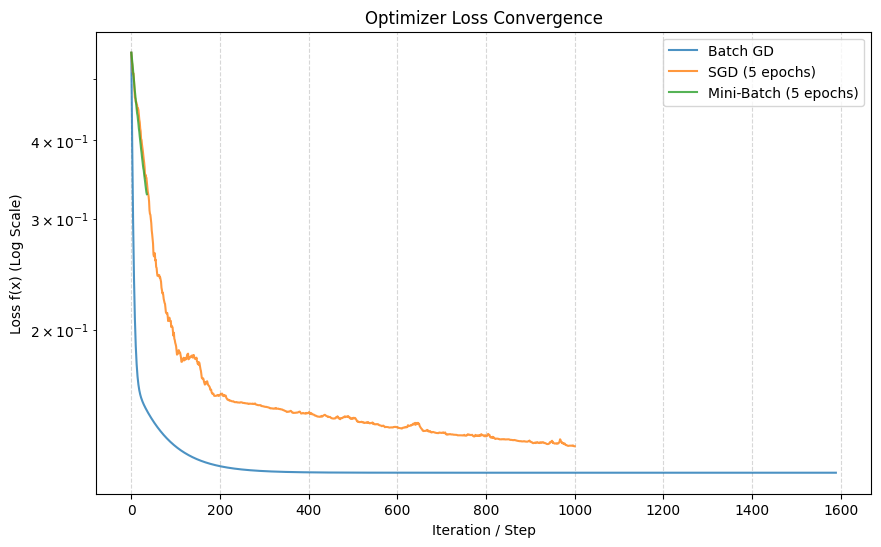

In [9]:
# --- 1. Instantiate Optimizers ---

# Batch GD
gd = GradientDescent(alpha=0.1) 

# SGD (5 epochs, N updates per epoch)
sgd = StochasticGradientDescent(alpha=0.01, n_epochs=5)

# Mini-Batch (5 epochs, N/B updates per epoch)
minibatch = MiniBatchGradientDescent(alpha=0.01, n_epochs=5, batch_size=32)

# --- 2. Run Optimizers ---

print("Running Batch GD...")
sol_gd, hist_gd = gd.optimize(
    x=W_initial_1D.copy(),
    func_callback=linear_reg_func,
    grad_func_callback=linear_reg_func.grad,
    is_plot=True
)
print(f"Batch GD done in {gd.num_iter} iterations.")


print("\nRunning SGD...")
# Note: SGD/MiniBatch optimizers override `optimize`
# and take X, Y directly, as per our implementation.
sol_sgd, hist_sgd = sgd.optimize(
    x=W_initial_2D.copy(), # Pass 2D weights
    X=X_aug,
    Y=Y,
    is_plot=True
)
print(f"SGD done in {sgd.n_epochs} epochs.")


print("\nRunning Mini-Batch GD...")
sol_mb, hist_mb = minibatch.optimize(
    x=W_initial_2D.copy(), # Pass 2D weights
    X=X_aug,
    Y=Y,
    is_plot=True
)
print(f"Mini-Batch GD done in {minibatch.n_epochs} epochs.")

# --- 3. Plot Loss Curves ---
print("\nGenerating loss curve comparison...")
plot_loss_curves(
    histories={
        "Batch GD": hist_gd,
        "SGD (5 epochs)": hist_sgd,
        "Mini-Batch (5 epochs)": hist_mb
    },
    loss_func_callable=final_loss_plotter
)